In [42]:
import pandas as pd
import numpy as np
import wrds
import datetime
import yfinance as yf
import pandas_datareader as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Codes

In [658]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
# set sample date range
begdate = '01/01/2000'
enddate = '10/31/2023'

# set CRSP date range a bit wider to guarantee collecting all information
crsp_begdate = '01/01/1999'
crsp_enddate = '11/20/2023'

In [4]:
#################################
# Step 0: Read in ICLINK output #
#################################

# iclink.csv is the output from the python program iclink
# it contains the linking between crsp and ibes
iclink = pd.read_csv('iclink.csv')

In [5]:
conn.list_libraries()

['aha_sample',
 'audit',
 'audit_audit_comp',
 'audit_common',
 'auditsmp',
 'auditsmp_all',
 'bank',
 'bank_all',
 'block',
 'block_all',
 'boardex_trial',
 'boardsmp',
 'bvd_amadeus_trial',
 'bvd_bvdbankf_trial',
 'bvd_orbis_trial',
 'bvdsamp',
 'calcbench_trial',
 'calcbnch',
 'cboe',
 'cboe_all',
 'ciqsamp',
 'ciqsamp_capstrct',
 'ciqsamp_common',
 'ciqsamp_keydev',
 'ciqsamp_pplintel',
 'ciqsamp_ratings',
 'ciqsamp_transactions',
 'ciqsamp_transcripts',
 'cisdmsmp',
 'columnar',
 'comp',
 'comp_execucomp',
 'comp_filings',
 'comp_global',
 'comp_global_daily',
 'comp_na_annual_all',
 'comp_na_daily_all',
 'comp_na_monthly_all',
 'comp_ph',
 'comp_pit',
 'comp_segments_hist',
 'comp_segments_hist_daily',
 'comp_snapshot',
 'comp_urq',
 'compa',
 'compg',
 'comph',
 'compm',
 'compsamp',
 'compsamp_all',
 'compsamp_snapshot',
 'compseg',
 'compsnap',
 'contrib',
 'contrib_as_filed_financials',
 'contrib_ceo_turnover',
 'contrib_char_returns',
 'contrib_general',
 'contrib_global_fac

In [6]:
conn.list_tables('wrdsapps_finratio_ibes_ccm')

['firm_ratio_ibes_ccm', 'id_ibes_ccm']

In [7]:
conn.get_table(library='wrdsapps_finratio_ibes_ccm', table='firm_ratio_ibes_ccm', obs=5)

gvkey   permno       adate       qdate public_date      capei      be  \
0  001000  25881.0  1969-12-31  1970-09-30  1971-01-31  10.949959  10.211   
1  001000  25881.0  1970-12-31  1970-12-31  1971-02-28  35.407426  10.544   
2  001000  25881.0  1970-12-31  1970-12-31  1971-03-31  31.031228  10.544   
3  001000  25881.0  1970-12-31  1970-12-31  1971-04-30  34.213918  10.544   
4  001000  25881.0  1970-12-31  1971-03-31  1971-05-31  11.306738  10.544   

         bm       evm pe_op_basic  ... ffi30_desc  ffi30  ffi38_desc  ffi38  \
0  0.427328  1.761483        None  ...       None   None       RUBBR   16.0   
1  0.431071  7.009840        None  ...       None   None       RUBBR   16.0   
2  0.431071  7.009840        None  ...       None   None       RUBBR   16.0   
3  0.431071  7.009840        None  ...       None   None       RUBBR   16.0   
4  0.431071  7.009840        None  ...       None   None       RUBBR   16.0   

   ffi48_desc  ffi48  ffi49_desc  ffi49  ticker     cusip  
0       RUBBR   15.0       RUBBR   15.0    None      None  
1       RUBBR   15.0       RUBBR   15.0      AE  00003210  
2       RUBBR   15.0       RUBBR   15.0      AE  00003210  
3       RUBBR   15.0       RUBBR   15.0      AE  00003210  
4       RUBBR   15.0       RUBBR   15.0      AE  00003210  

[5 rows x 100 columns]

In [8]:
##################################
# Step 1. S&P 500 Index Universe #
##################################

# All companies that were ever included in S&P 500 index as an example
# Old version of the code uses comp.idxcst_his

# New code uses crsp.msp500list
# Linking Compustat GVKEY and IBES Tickers using ICLINK               
# For unmatched GVKEYs, use header IBTIC link in Compustat Security file 


sp500 = conn.raw_sql(f"""
                        select a.*
                        from crsp.msp500list as a;
                        """, date_cols=['start', 'ending'])

# CCM data
_ccm = conn.raw_sql(""" select gvkey, lpermco as permco, lpermno as permno, 
                        linkdt, linkenddt 
                        from crsp.ccmxpf_linktable 
                        where usedflag=1 
                        and linkprim in ('P', 'C')""", date_cols=['linkdt', 'linkenddt'])

_ccm[['permco', 'permno']] = _ccm[['permco', 'permno']].astype(int)

# Fill linkenddt missing value (.E in SAS dataset) with today's date
_ccm['linkenddt'] = _ccm.linkenddt.fillna(datetime.date.today())

_sec = conn.raw_sql(""" select ibtic, gvkey from comp.security """)


# Start the sequence of left join
gvkey = pd.merge(sp500, _ccm, how='left', on=['permno'])
gvkey = pd.merge(gvkey, _sec.loc[_sec.ibtic.notna()], how='left', on=['gvkey'])

# high quality links from iclink
# score = 0 or 1
iclink_hq = iclink.loc[(iclink.score <=1)]

gvkey = pd.merge(gvkey, iclink_hq, how='left', on=['permno'])

# fill missing ticker with ibtic
gvkey.ticker = np.where(gvkey.ticker.notnull(), gvkey.ticker, gvkey.ibtic)

# Keep relevant columns and drop duplicates if there is any
gvkey = gvkey[['gvkey', 'permco', 'permno', 'linkdt', 'linkenddt','ticker']]

gvkey = gvkey.drop_duplicates()

# date ranges from gvkey
# min linkdt for ticker and permno combination
gvkey_mindt = gvkey.groupby(['ticker','permno']).linkdt.min().reset_index()

# max linkenddt for ticker and permno combination
gvkey_maxdt = gvkey.groupby(['ticker','permno']).linkenddt.max().reset_index()

# link date range 
gvkey_dt = pd.merge(gvkey_mindt, gvkey_maxdt, how='inner', on=['ticker','permno'])

In [9]:
#######################################
# Step 2. Extract Estimates from IBES #
#######################################

# Extract estimates from IBES Unadjusted file and select    
# the latest estimate for a firm within broker-analyst group
# "fpi in (6,7)" selects quarterly forecast for the current 
# and the next fiscal quarter    

ibes_temp = conn.raw_sql(f"""
                        select ticker, estimator, analys, pdf, fpi, value, 
                        fpedats, revdats, revtims, anndats, anntims
                        from ibes.detu_epsus 
                        where fpedats between '{begdate}' and '{enddate}'
                        and (fpi='6' or fpi='7')
                        """, date_cols = ['revdats', 'anndats', 'fpedats'])


# merge to get date range linkdt and linkenddt to fulfill date requirement
ibes_temp = pd.merge(ibes_temp, gvkey_dt, how='left', on=['ticker'])
ibes_temp = ibes_temp.loc[(ibes_temp.linkdt<=ibes_temp.anndats) & (ibes_temp.anndats <= ibes_temp.linkenddt)]

In [10]:
# Count number of estimates reported on primary/diluted basis 

p_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='P']
d_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='D']

p_count = p_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'p_count'})
d_count = d_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'d_count'})

ibes = pd.merge(ibes_temp, d_count, how = 'left', on=['ticker', 'fpedats'])
ibes = pd.merge(ibes, p_count, how='left', on =['ticker','fpedats'])
ibes['d_count'] = ibes.d_count.fillna(0)
ibes['p_count'] = ibes.p_count.fillna(0)

# Determine whether most analysts report estimates on primary/diluted basis
# following Livnat and Mendenhall (2006)                                   

ibes['basis']=np.where(ibes.p_count>ibes.d_count, 'P', 'D')

ibes = ibes.sort_values(by=['ticker','fpedats','estimator','analys','anndats', 'anntims', 'revdats', 'revtims'])\
.drop(['linkdt', 'linkenddt','p_count','d_count', 'pdf', 'fpi'], axis=1)

# Keep the latest observation for a given analyst
# Group by company fpedats estimator analys then pick the last record in the group

ibes_1 = ibes.groupby(['ticker','fpedats','estimator','analys']).apply(lambda x: x.index[-1]).to_frame().reset_index()

# reset index to the old dataframe index for join in the next step
ibes_1=ibes_1.set_index(0)

# Inner join with the last analyst record per group
ibes = pd.merge(ibes, ibes_1[['analys']], left_index=True, right_index=True)

# drop duplicate column
ibes=ibes.drop(['analys_y'], axis=1).rename(columns={'analys_x': 'analys'})

In [11]:
#######################################
# Step 3. Link Estimates with Actuals #
#######################################

# Link Unadjusted estimates with Unadjusted actuals and CRSP permnos  
# Keep only the estimates issued within 90 days before the report date

# Getting actual piece of data
ibes_act = conn.raw_sql(f"""
                        select ticker, anndats as repdats, value as act, pends as fpedats, pdicity
                        from ibes.actu_epsus 
                        where pends between '{begdate}' and '{enddate}'
                        and pdicity='QTR'
                        """, date_cols = ['repdats', 'fpedats'])


# Join with the estimate piece of the data

ibes1 = pd.merge(ibes, ibes_act, how='left', on = ['ticker','fpedats'])
ibes1['dgap'] = ibes1.repdats - ibes1.anndats

ibes1['flag'] = np.where( (ibes1.dgap>=datetime.timedelta(days=0)) & (ibes1.dgap<=datetime.timedelta(days=90)) & (ibes1.repdats.notna()) & (ibes1.anndats.notna()), 1, 0)

ibes1 = ibes1.loc[ibes1.flag==1].drop(['flag', 'dgap', 'pdicity'], axis=1)

# Select all relevant combinations of Permnos and Date

ibes1_dt1 = ibes1[['permno', 'anndats']].drop_duplicates()

ibes1_dt2 = ibes1[['permno', 'repdats']].drop_duplicates().rename(columns={'repdats':'anndats'})

ibes_anndats = pd.concat([ibes1_dt1, ibes1_dt2]).drop_duplicates()

In [12]:
# Adjust all estimate and earnings announcement dates to the closest
# preceding trading date in CRSP to ensure that adjustment factors won't
# be missing after the merge  

# unique anndats from ibes
uniq_anndats = ibes_anndats[['anndats']].drop_duplicates()

# unique trade dates from crsp.dsi
crsp_dats = conn.raw_sql(""" 
                            select date 
                            from crsp.dsi 
                         """, date_cols=['date'])

# Create up to 5 days prior dates relative to anndats

for i in range(0, 5):
    uniq_anndats[i] = uniq_anndats.anndats - datetime.timedelta(days=i)

# reshape (transpose) the df for later join with crsp trading dates

expand_anndats = uniq_anndats.set_index('anndats').stack().reset_index().\
rename(columns={'level_1':'prior', 0:'prior_date'})

# merge with crsp trading dates
tradedates = pd.merge(expand_anndats, crsp_dats, how='left', left_on=['prior_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
tradedates['dgap'] = tradedates.anndats-tradedates.date

# choosing the row with the smallest dgap for a given anndats
def get_minDgap(g):
    try:
        return g['dgap'].idxmin()
    except:
        return
tradedates = tradedates.loc[tradedates.groupby('anndats').apply(get_minDgap).dropna()]

tradedates = tradedates[['anndats', 'date']]

In [13]:
# merge the CRSP adjustment factors for all estimate and report dates

# extract CRSP adjustment factors
cfacshr = conn.raw_sql(f"""
                        select permno, date, cfacshr
                        from crsp.dsf
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])

ibes_anndats = pd.merge(ibes_anndats, tradedates, how='left', on = ['anndats'])

ibes_anndats = pd.merge(ibes_anndats, cfacshr, how='left', on=['permno', 'date'])


In [14]:
#########################################
# Step 4. Adjust Estimates with CFACSHR #
#########################################

# Put the estimate on the same per share basis as
# company reported EPS using CRSP Adjustment factors. 
# New_value is the estimate adjusted to be on the 
# same basis with reported earnings.

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', on=['permno', 'anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_ann'})

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', left_on=['permno', 'repdats'], right_on=['permno','anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_rep'})

ibes1['new_value'] = (ibes1.cfacshr_rep/ibes1.cfacshr_ann)*ibes1.value

# Sanity check: there should be one most recent estimate for 
# a given firm-fiscal period end combination 
ibes1 = ibes1.sort_values(by=['ticker','fpedats','estimator','analys']).drop_duplicates()

In [15]:
del _ccm 
del _sec
del iclink
del gvkey_mindt
del gvkey_maxdt
del ibes_temp 
del p_sub 
del d_sub
del p_count
del d_count
del gvkey_dt
del ibes1_dt1
del ibes1_dt2
del ibes_act
del tradedates
del ibes
del ibes_anndats

In [16]:
ibes1DDD = ibes1[ibes1.basis=='D']

In [17]:
ibes1DDD = ibes1DDD[ibes1DDD['new_value'].notnull()]

In [18]:
def summaryStat(g):
    g['meanest'] = g['new_value'].mean()
    g['medest'] = g['new_value'].median()
    g['stdest'] = g['new_value'].std()
    g['countest'] = g['new_value'].count()
    return g.iloc[0][['meanest','medest','stdest','countest']]
ibesSummary = ibes1DDD.groupby(['ticker','permno','fpedats','repdats','act']).apply(summaryStat)

In [19]:
crsp_price = conn.raw_sql(f""" 
                            select permno,prc,cfacpr,date
                            from crsp.dsf
                            where date between '{crsp_begdate}' and '{crsp_enddate}'
                         """, date_cols=['date'])

In [20]:
crsp_price['prc'] = crsp_price['prc'].abs()
crsp_price['prc'] = crsp_price['prc']/crsp_price['cfacpr']

In [659]:
sp500 = conn.raw_sql(f"""
                        select a.*
                        from crsp.msp500list as a;
                        """, date_cols=['start', 'ending'])

In [675]:
sp500

permno      start     ending
0    10006.0000 1957-03-01 1984-07-18
1    10030.0000 1957-03-01 1969-01-08
2    10049.0000 1925-12-31 1932-10-01
3    10057.0000 1957-03-01 1992-07-02
4    10078.0000 1992-08-20 2010-01-28
...         ...        ...        ...
2024 93159.0000 2012-07-31 2016-03-29
2025 93246.0000 2021-03-22 2022-12-30
2026 93422.0000 2010-07-01 2015-06-30
2027 93429.0000 2017-03-01 2022-12-30
2028 93436.0000 2020-12-21 2022-12-30

[2029 rows x 3 columns]

In [691]:
def get_date(row):
    df = pd.DataFrame()
    #try:
    startDate = row['start']
    endDate = row['ending']
    df['date'] = pd.date_range(startDate,endDate,freq='B').values
    df['permno'] = row['permno']
    return df
    #except:
    #    return
sp500_date = pd.concat(sp500.dropna().apply(get_date,axis=1).to_list())

In [692]:
sp500_date

date     permno
0   1957-03-01 10006.0000
1   1957-03-04 10006.0000
2   1957-03-05 10006.0000
3   1957-03-06 10006.0000
4   1957-03-07 10006.0000
..         ...        ...
525 2022-12-26 93436.0000
526 2022-12-27 93436.0000
527 2022-12-28 93436.0000
528 2022-12-29 93436.0000
529 2022-12-30 93436.0000

[9328586 rows x 2 columns]

In [702]:
crsp_price2 = pd.merge(crsp_price,sp500_date,how='inner',on=['permno','date'])

In [21]:
ibesSummary = ibesSummary.reset_index()

In [22]:
ibesSummary['sup'] = (ibesSummary['act'] - ibesSummary['medest'])/ibesSummary['medest']

#def get_tsSup(group):
#    group = group.sort_values('repdats')
#    group['tssup'] = (group['act'] - group['act'].shift(4))/group['act'].shift(4)
#    return group
#ibesSummary = ibesSummary.groupby('permno').apply(get_tsSup).reset_index(drop=True)

In [724]:
def getZ(group):
    group = group.sort_values('repdats')
    group['supz'] = (group['sup'] - group['sup'].rolling(8).mean())/group['sup'].rolling(8).std()
    group['supz_0mean'] = (group['sup'])/group['sup'].rolling(8).std()
    #print(group)
    return group
ibesSummary = ibesSummary.groupby(['ticker','permno']).apply(getZ).reset_index(drop=True)
ibesSummary['long_pos'] = np.where((ibesSummary['supz_0mean']>0),1,np.nan)
ibesSummary['short_pos'] = np.where((ibesSummary['supz_0mean']<0),-1,0)
ibesSummary['pos'] = ibesSummary['long_pos']#+ibesSummary['short_pos']

In [725]:
def getPosition(group,duration=5):
    try:
        dateRange = pd.date_range('1800-01-01','1800-01-01')
        for date in group['repdats']:
            startDate = date
            endDate = date + datetime.timedelta(duration)
            dateRange = dateRange.union(pd.date_range(startDate,periods=duration,freq='B'))
        group = group.set_index('repdats')['pos']
        position = group.reindex(dateRange[1:].drop_duplicates()).ffill()
        return position
    except:
        return
positions = ibesSummary.groupby(['permno','repdats']).apply(getPosition,7)
positions = positions.reset_index()
positions.columns = ['permno','repdats','date','pos']
crsp_price = crsp_price[crsp_price['permno'].isin(positions['permno'].unique())]
def getPct(group):
    group['pct'] = group['prc'].pct_change()
    return group
crsp_pct = crsp_price.groupby('permno').apply(getPct).reset_index(drop=True)
#crsp_pct = crsp_pct[(crsp_pct['pct']>=crsp_pct['pct'].quantile(.0001))&(crsp_pct['pct']<=crsp_pct['pct'].quantile(.9999))]
def mergePosition(group,positions):
    position = positions[positions['permno'] == group.name]
    group = pd.merge(group,position,on=['date','permno'])
    group = group[group['prc'].notna()]
    return group
mergedCrspPrice = crsp_pct.groupby('permno').apply(mergePosition,positions).reset_index(drop=True)
mergedCrspPrice['longpos'] = mergedCrspPrice['pos']
mergedCrspPrice.loc[mergedCrspPrice['longpos']<0,'longpos'] = 0
def getRet(group):
    group = group.sort_values('date')
    group['ret'] = group['pct']*group['pos'].shift(2)
    group['longret'] = group['pct']*group['longpos'].shift(2)
    #print(group)
    return group
stratRet = mergedCrspPrice.groupby(['permno','repdats']).apply(getRet).reset_index(drop=True)
def getPortRet(group):
    return group['ret'].mean()
def getPortLongRet(group):
    return group['longret'].mean()
portRet = pd.DataFrame()
portRet['longshort'] = stratRet.groupby('date').apply(getPortRet)
portRet['long'] = stratRet.groupby('date').apply(getPortLongRet)

C:\Users\benka\AppData\Local\Temp\ipykernel_17316\4026450729.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:].drop_duplicates()).ffill()
C:\Users\benka\AppData\Local\Temp\ipykernel_17316\4026450729.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:].drop_duplicates()).ffill()
C:\Users\benka\AppData\Local\Temp\ipykernel_17316\4026450729.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:].drop_duplicates()).ffill()
C:\Users\benka\AppData\Local\Temp\ipykernel_17316\4026450729.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:].drop_duplicates()).ffill()
C:\Users\benka\AppData\Local\Temp\ipykernel_17316\4026450729

In [726]:
dividend = pd.read_excel('shy dividend.xlsx')
dividend = dividend.set_index('Ex/EFF DATE')
dividend = dividend[['CASH AMOUNT']]
dividend.index.name = None
dividend.index = pd.DatetimeIndex(dividend.index)
dividend

CASH AMOUNT
2023-01-11       0.2303
2023-02-10       0.2091
2023-01-09       0.2058
2023-01-08       0.2118
2023-03-07       0.2060
...                 ...
2003-03-02       0.1217
2002-02-12       0.1205
2002-01-11       0.1329
2002-01-10       0.1198
2002-03-09       0.1325

[183 rows x 1 columns]

In [727]:
spy = yf.download('SPY')['Adj Close'].pct_change()
bnd = yf.download('SHY')['Adj Close'].pct_change()

hedgedRet = (portRet*.7).add(shy['totalret']*.3,axis=0)[:'2022-12-30']
hedgedRet

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


longshort    long
2000-02-08        NaN     NaN
2000-02-09        NaN     NaN
2000-02-10        NaN     NaN
2000-02-11        NaN     NaN
2000-02-14        NaN     NaN
...               ...     ...
2022-12-23     0.0028  0.0028
2022-12-27     0.0006  0.0006
2022-12-28    -0.0102 -0.0102
2022-12-29     0.0147  0.0147
2022-12-30    -0.0058 -0.0058

[5812 rows x 2 columns]

In [729]:
pd.set_option('display.float_format', '{:.4f}'.format)
Evaluator('long only',df['PEAK'],fourFactor,majorAssetReturn).get_summary()

Value  Sample size  P-value
Cum Return        11.0432       1.0000      NaN
Mean               0.1356    5142.0000      NaN
Vol                0.1651    5142.0000      NaN
SR                 0.7509    5142.0000      NaN
CAPM Alpha         0.0551    5142.0000   0.0092
Carhart Alpha      0.0563    5142.0000   0.0056
Skew               0.0891    5142.0000      NaN
Skew (M)          -0.4445     246.0000      NaN
Kurt              16.0087    5142.0000      NaN
Avg Drawdown      -0.0411    4533.0000      NaN
Max Drawdown      -0.3377       1.0000      NaN
Downside Risk      0.1211    2703.0000      NaN
VaR 95%           -0.0148    5142.0000      NaN
Exp Shortfall 95% -0.0236     258.0000      NaN
VaR 99%           -0.0263    5142.0000      NaN
Exp Shortfall 99% -0.0415      52.0000      NaN

In [451]:
pd.set_option('display.float_format', '{:.4f}'.format)
Evaluator('long only',df['S&P 500'],fourFactor,majorAssetReturn).get_summary()

Value  Sample size  P-value
Cum Return         5.6458       1.0000      NaN
Mean               0.1123    5142.0000      NaN
Vol                0.1968    5142.0000      NaN
SR                 0.5113    5142.0000      NaN
CAPM Alpha        -0.0000    5142.0000   0.0000
Carhart Alpha      0.0000    5142.0000   0.0000
Skew              -0.2825    5142.0000      NaN
Skew (M)          -0.5731     246.0000      NaN
Kurt              10.4692    5142.0000      NaN
Avg Drawdown      -0.0800    4551.0000      NaN
Max Drawdown      -0.5468       1.0000      NaN
Downside Risk      0.1381    2806.0000      NaN
VaR 95%           -0.0188    5142.0000      NaN
Exp Shortfall 95% -0.0302     258.0000      NaN
VaR 99%           -0.0350    5142.0000      NaN
Exp Shortfall 99% -0.0513      52.0000      NaN

In [728]:
df = pd.DataFrame()
#df['PEAK Strategy'] = portRet['long'][portRet['long'].first_valid_index():].fillna(0)*.7
df['PEAK'] = hedgedRet['long'][hedgedRet['long'].first_valid_index():].fillna(0)
df['S&P 500'] = fourFactor['Mkt-RF'] + fourFactor['RF']
df.dropna(inplace = True)

#### equity curve

Text(2022-03-05 00:00:00, 4.984322298525667, '6.65x')

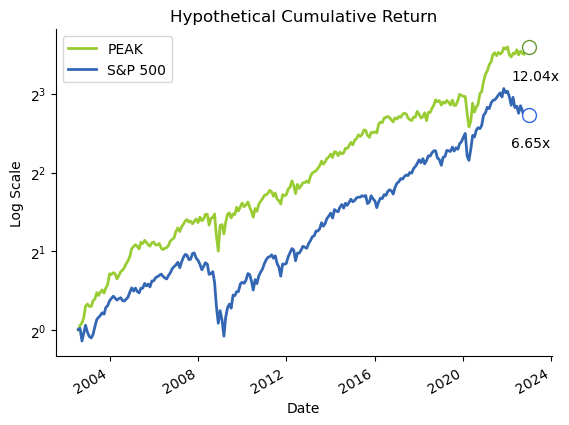

In [730]:
growth = (1+df).cumprod()
ax = growth[::21].plot(color=[(0.6,0.8,0.2),(0.2,0.4,0.7)],
                 linewidth=2)
plt.yscale('log',base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Log Scale')

ax.set_title('Hypothetical Cumulative Return')

ax.plot(growth.index[-1], growth['PEAK'][-1],
        marker='o',
        markersize=10,
        color=(0.4,0.6,0.2),
        markerfacecolor='white')
ax.annotate('{:.2f}x'.format(growth['PEAK'][-1]),
            xy=(growth.index[-1]-datetime.timedelta(300),growth['PEAK'][-1]*0.75))

ax.plot(growth.index[-1], growth['S&P 500'][-1],
        marker='o',
        markersize=10,
        color=(0.2,0.4,0.9),
        markerfacecolor='white')
ax.annotate('{:.2f}x'.format(growth['S&P 500'][-1]),
            xy=(growth.index[-1]-datetime.timedelta(300),growth['S&P 500'][-1]*0.75))

#### comparison

In [409]:
spy = yf.download('SPY')['Adj Close'].pct_change()
tlt = yf.download('TLT')['Adj Close'].pct_change()
iyr = yf.download('IYR')['Adj Close'].pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [435]:
df2 = pd.DataFrame()
df2['PEAK'] = hedgedRet['long'][hedgedRet['long'].first_valid_index():].fillna(0)
df2['SPY (Equities)'] = spy
df2['TLT (Long-term Treasury)'] = tlt
df2['IYR (Real Estate)'] = iyr

In [436]:
sumStat = pd.DataFrame()
sumStat['Exp. Return'] = df2.mean()*252
sumStat['Exp. Volatility'] = df2.std()*np.sqrt(252)
sumStat['Sharpe Ratio'] = (df2.subtract(fourFactor['RF'],axis=0)).mean()*252/sumStat['Exp. Volatility']

In [760]:
sumStat.T

PEAK  SPY (Equities)  TLT (Long-term Treasury)  \
Exp. Return     0.1343          0.1085                    0.0534   
Exp. Volatility 0.1644          0.1938                    0.1428   
Sharpe Ratio    0.7544          0.4997                    0.2926   

                 IYR (Real Estate)  
Exp. Return                 0.1147  
Exp. Volatility             0.2794  
Sharpe Ratio                0.3688

In [539]:
otherHF = pd.DataFrame({'Mutual Funds':[-.42*12],
                        'Low HFs':[-.10*12],
                        'Medium HFs':[.10*12],
                        'High HFs':[.41*12],
                        'PEAK':[5.5]},index=['Annualized Alpha'])
otherHF

Mutual Funds  Low HFs  Medium HFs  High HFs   PEAK
Annualized Alpha       -5.0400  -1.2000      1.2000    4.9200 5.5000

In [567]:
otherHF[label]

Annualized Alpha   -5.0400
Name: Mutual Funds, dtype: float64

"\nplt.yscale('log',base=2)\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\nax.set_xlabel('Date')\nax.set_ylabel('Capital Growth')\n\nax.plot(growth.index[-1], growth['PEAK Fund'][-1],\n        marker='o',\n        markersize=10,\n        color=(0.4,0.6,0.2),\n        markerfacecolor='white')\nax.annotate('{:.2f}x'.format(growth['PEAK Fund'][-1]),\n            xy=(growth.index[-1]-datetime.timedelta(300),growth['PEAK Fund'][-1]*0.75))\n\nax.plot(growth.index[-1], growth['S&P 500'][-1],\n        marker='o',\n        markersize=10,\n        color=(0.2,0.4,0.9),\n        markerfacecolor='white')\nax.annotate('{:.2f}x'.format(growth['S&P 500'][-1]),\n            xy=(growth.index[-1]-datetime.timedelta(300),growth['S&P 500'][-1]*0.75))\n"

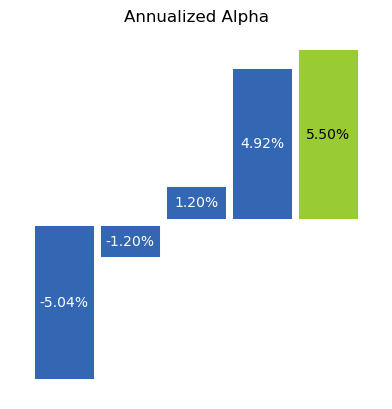

In [647]:


ax = otherHF.plot(kind='bar',
                  figsize=(6.4*.75,4.8),
                  edgecolor='white', 
                  width=4,
                  linewidth=5,
                  legend=None,
                  color=[(0.2,0.4,0.7),(0.2,0.4,0.7),(0.2,0.4,0.7),(0.2,0.4,0.7),(0.6,0.8,0.2)])
#plt.gca().invert_yaxis()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Annualized Alpha',rotation=0)
ax.set_title('Annualized Alpha')
ax.set_ylabel('%')

for bar,label in zip(ax.patches[:4],otherHF):
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
        ax.annotate('{:.2f}%'.format(bar.get_height()), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()*0.5), ha='center', va='center',
                    color='white')

for bar in ax.patches[4:]:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
        ax.annotate('{:.2f}%'.format(bar.get_height()), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()*0.5), ha='center', va='center',
                    color='black')
        

'''
plt.yscale('log',base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Capital Growth')

ax.plot(growth.index[-1], growth['PEAK Fund'][-1],
        marker='o',
        markersize=10,
        color=(0.4,0.6,0.2),
        markerfacecolor='white')
ax.annotate('{:.2f}x'.format(growth['PEAK Fund'][-1]),
            xy=(growth.index[-1]-datetime.timedelta(300),growth['PEAK Fund'][-1]*0.75))

ax.plot(growth.index[-1], growth['S&P 500'][-1],
        marker='o',
        markersize=10,
        color=(0.2,0.4,0.9),
        markerfacecolor='white')
ax.annotate('{:.2f}x'.format(growth['S&P 500'][-1]),
            xy=(growth.index[-1]-datetime.timedelta(300),growth['S&P 500'][-1]*0.75))
'''

In [64]:
portRet.fillna(0).to_csv('stratRet.csv')

#### rolling alpha

In [480]:
evaluator = Evaluator('long only',df['PEAK Fund'],fourFactor,majorAssetReturn)

In [504]:
evaluator.get_CarhartSummary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Strategy-RF   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     2887.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:51:25   Log-Likelihood:                 19209.
No. Observations:                5142   AIC:                        -3.841e+04
Df Residuals:                    5137   BIC:                        -3.838e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   8.06e-05      2.774      0.006    6.56e-05       0.000
Mkt-RF         0.6453      0.007     93.839      0.000       0.632       0.659
SMB            0.1918      0.013     14.238      0.000       0.165       0.218
HML            0.1388      0.012     11.964      0.000       0.116       0.162
Mom           -0.0445      0.009     -5.047      0.000      -0.062      -0.027
==============================================================================
Omnibus:                     2412.371   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           167965.453
Skew:                           1.394   Prob(JB):                         0.00
Kurtosis:                      30.860   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [527]:
(df['PEAK Fund']-df['S&P 500']).mean()/(df['PEAK Fund']-df['S&P 500']).std()*np.sqrt(252)

0.20538993288621515

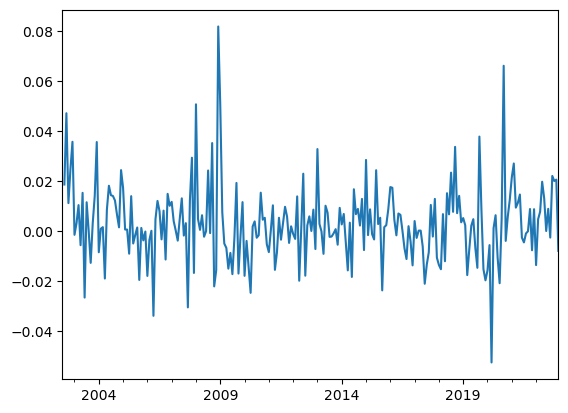

In [521]:
def get_yearAlpha(group):
    Y = group['PEAK Fund']
    X = sm.add_constant(group['S&P 500'])
    model = sm.OLS(Y,X)
    result = model.fit()
    try:
        alpha = result.params['const']
        return alpha
    except:
        return
monthly = df.resample('M').apply(get_yearAlpha)
confidence = monthly.mean()*12
ax = (monthly*12).plot()
plt.hlines(y=monthly*12,xmin=monthly.index[0],xmax=monthly.index[-1],color='red')
#ax.plot(monthly.index,np.arange(len(monthly.index)))


In [491]:
Y = df['PEAK Fund']
X = sm.add_constant(df['S&P 500'])
model = sm.OLS(Y,X)
result = model.fit()
alpha = result.params[0]
result.summary()

0.0002329850364514808


#### correlation

In [623]:
evaluator.get_CarhartSummary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Strategy-RF   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     2887.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:20:56   Log-Likelihood:                 19209.
No. Observations:                5142   AIC:                        -3.841e+04
Df Residuals:                    5137   BIC:                        -3.838e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   8.06e-05      2.774      0.006    6.56e-05       0.000
Mkt-RF         0.6453      0.007     93.839      0.000       0.632       0.659
SMB            0.1918      0.013     14.238      0.000       0.165       0.218
HML            0.1388      0.012     11.964      0.000       0.116       0.162
Mom           -0.0445      0.009     -5.047      0.000      -0.062      -0.027
==============================================================================
Omnibus:                     2412.371   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           167965.453
Skew:                           1.394   Prob(JB):                         0.00
Kurtosis:                      30.860   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

"\nax.plot(growth2.index[-1], growth2['PEAK-Rf'][-1],\n        marker='o',\n        markersize=10,\n        color=(0.4,0.6,0.2),\n        markerfacecolor='white')\nax.annotate('{:.2f}x'.format(growth2['PEAK-Rf'][-1]),\n            xy=(growth2.index[-1]-datetime.timedelta(300),growth2['PEAK-Rf'][-1]*0.75))\n"

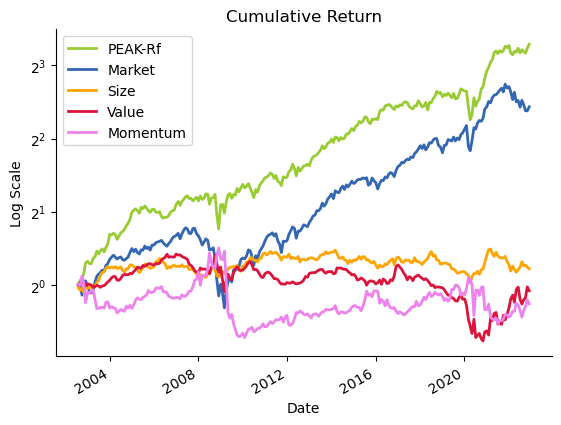

In [632]:
df3 = evaluator.fourFactor[['Strategy-RF','Mkt-RF','SMB','HML','Mom   ']]
df3.columns = ['PEAK-Rf','Market','Size','Value','Momentum']

growth2 = (1+df3).cumprod()
ax = growth2[::21].plot(color=[(0.6,0.8,0.2),(0.2,0.4,0.7),'orange','crimson','violet'],
                 linewidth=2)
plt.yscale('log',base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Log Scale')

ax.set_title('Cumulative Return')

'''
ax.plot(growth2.index[-1], growth2['PEAK-Rf'][-1],
        marker='o',
        markersize=10,
        color=(0.4,0.6,0.2),
        markerfacecolor='white')
ax.annotate('{:.2f}x'.format(growth2['PEAK-Rf'][-1]),
            xy=(growth2.index[-1]-datetime.timedelta(300),growth2['PEAK-Rf'][-1]*0.75))
'''

#### Risk metrics

In [635]:
evaluator.get_summary()

Value  Sample size  P-value
Cum Return        11.0432       1.0000      NaN
Mean               0.1356    5142.0000      NaN
Vol                0.1651    5142.0000      NaN
SR                 0.7509    5142.0000      NaN
CAPM Alpha         0.0551    5142.0000   0.0092
Carhart Alpha      0.0563    5142.0000   0.0056
Skew               0.0891    5142.0000      NaN
Skew (M)          -0.4445     246.0000      NaN
Kurt              16.0087    5142.0000      NaN
Avg Drawdown      -0.0411    4533.0000      NaN
Max Drawdown      -0.3377       1.0000      NaN
Downside Risk      0.1211    2703.0000      NaN
VaR 95%           -0.0148    5142.0000      NaN
Exp Shortfall 95% -0.0236     258.0000      NaN
VaR 99%           -0.0263    5142.0000      NaN
Exp Shortfall 99% -0.0415      52.0000      NaN

In [645]:
Evaluator('500',df['S&P 500'],fourFactor,majorAssetReturn).get_summary()

Value  Sample size  P-value
Cum Return         5.6458       1.0000      NaN
Mean               0.1123    5142.0000      NaN
Vol                0.1968    5142.0000      NaN
SR                 0.5113    5142.0000      NaN
CAPM Alpha        -0.0000    5142.0000   0.0000
Carhart Alpha      0.0000    5142.0000   0.0000
Skew              -0.2825    5142.0000      NaN
Skew (M)          -0.5731     246.0000      NaN
Kurt              10.4692    5142.0000      NaN
Avg Drawdown      -0.0800    4551.0000      NaN
Max Drawdown      -0.5468       1.0000      NaN
Downside Risk      0.1381    2806.0000      NaN
VaR 95%           -0.0188    5142.0000      NaN
Exp Shortfall 95% -0.0302     258.0000      NaN
VaR 99%           -0.0350    5142.0000      NaN
Exp Shortfall 99% -0.0513      52.0000      NaN

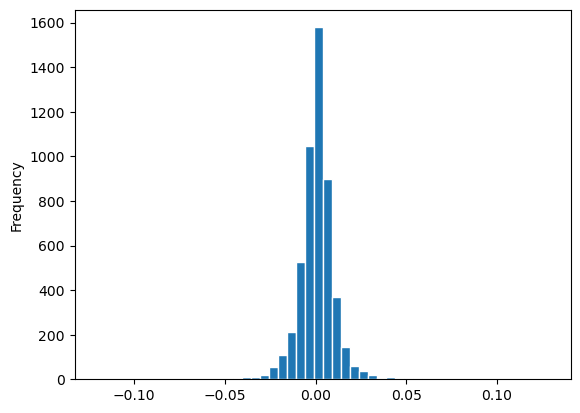

In [644]:
ax = df['PEAK'].plot(kind='hist',
                     bins=100,
                     edgecolor='white')
ax.grid(False)

## Evaluation

### import stuff

In [26]:
threeFactor = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='2000-01-01',end='2023-11-20').read()[0]/100
momFactor = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='2000-01-01',end='2023-11-20').read()[0]/100
fourFactor = pd.concat([threeFactor,momFactor],axis=1)

In [27]:
majorAssetReturn = yf.download(['SPY','BND','VNQ'])['Adj Close'].pct_change()

[*********************100%***********************]  3 of 3 completed


In [287]:
class Evaluator():
  def __init__(self,name,returns,fourFactor,majorAssetReturn):
    self.name = name
    self.set_returns(returns)
    self.set_fourFactor(fourFactor)
    self.set_majorAssetReturn(majorAssetReturn)
  def set_fourFactor(self,fourFactor):
    self.fourFactor = fourFactor.copy()
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_majorAssetReturn(self,majorAssetReturn):
    self.majorAssetReturn = majorAssetReturn
    self.majorAssetReturn['Strategy'] = self.returns
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_majorAssetCorr(self):
    return self.majorAssetReturn.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()*252/self.get_vol()[0]
    sampleSize = self.returns.size
    return sharpeRatio,sampleSize
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

### Evaluate

In [389]:
df['S&P 500']

0.00045426346406455246

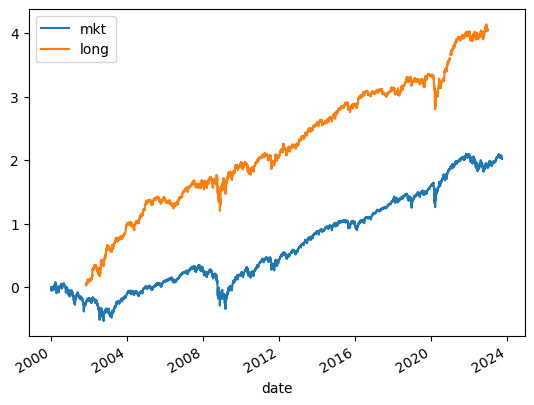

In [272]:
(fourFactor['Mkt-RF']+fourFactor['RF']).cumsum().plot()
(portRet['long']).cumsum().plot()
plt.legend(['mkt','long'])

TypeError: Axes.hlines() missing 2 required positional arguments: 'xmin' and 'xmax'

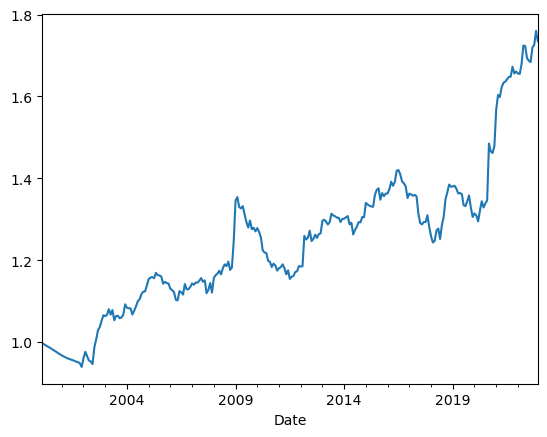

In [83]:
def get_yearAlpha(group):
    Y = group['Strategy-RF']
    X = sm.add_constant(group[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*12
    return alpha
monthly = evaluator.fourFactor.resample('M').apply(get_yearAlpha)
ax = (1+monthly).cumprod().plot()
ax.plot()

In [378]:
pd.set_option('display.float_format', '{:.4f}'.format)
evaluator = Evaluator('long only',df['PEAK Fund'],fourFactor,majorAssetReturn)
evaluator.get_summary()

Value  Sample size  P-value
Cum Return        11.0432       1.0000      NaN
Mean               0.1309    5329.0000      NaN
Vol                0.1622    5329.0000      NaN
SR                 0.7274    5329.0000      NaN
CAPM Alpha         0.0496    5329.0000   0.0168
Carhart Alpha      0.0521    5329.0000   0.0093
Skew               0.0962    5329.0000      NaN
Skew (M)          -0.4215     255.0000      NaN
Kurt              16.6964    5329.0000      NaN
Avg Drawdown      -0.0418    4720.0000      NaN
Max Drawdown      -0.3377       1.0000      NaN
Downside Risk      0.1189    2703.0000      NaN
VaR 95%           -0.0145    5329.0000      NaN
Exp Shortfall 95% -0.0233     267.0000      NaN
VaR 99%           -0.0260    5329.0000      NaN
Exp Shortfall 99% -0.0409      54.0000      NaN

In [391]:
df['PEAK Fund']

2002-07-31    0.0028
2002-08-01   -0.0146
2002-08-02   -0.0218
2002-08-05   -0.0219
2002-08-06    0.0295
               ...  
2023-09-25    0.0000
2023-09-26    0.0000
2023-09-27    0.0000
2023-09-28    0.0000
2023-09-29    0.0000
Name: PEAK Fund, Length: 5329, dtype: float64

In [386]:
pd.set_option('display.float_format', '{:.4f}'.format)
evaluator = Evaluator('long only',df['S&P 500'],fourFactor,majorAssetReturn)
evaluator.get_summary()

Value  Sample size  P-value
Cum Return         6.5152       1.0000      NaN
Mean               0.1145    5329.0000      NaN
Vol                0.1951    5329.0000      NaN
SR                 0.5209    5329.0000      NaN
CAPM Alpha        -0.0000    5329.0000   0.2050
Carhart Alpha      0.0000    5329.0000   0.0000
Skew              -0.2810    5329.0000      NaN
Skew (M)          -0.5628     255.0000      NaN
Kurt              10.4919    5329.0000      NaN
Avg Drawdown      -0.0818    4738.0000      NaN
Max Drawdown      -0.5468       1.0000      NaN
Downside Risk      0.1370    2906.0000      NaN
VaR 95%           -0.0186    5329.0000      NaN
Exp Shortfall 95% -0.0298     267.0000      NaN
VaR 99%           -0.0346    5329.0000      NaN
Exp Shortfall 99% -0.0507      54.0000      NaN

In [36]:
evaluator.get_CAPMSummary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Strategy-RF   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:23:15   Log-Likelihood:                 24943.
No. Observations:                5760   AIC:                        -4.988e+04
Df Residuals:                    5758   BIC:                        -4.987e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.561e-05    4.2e-05      1.563      0.118   -1.67e-05       0.000
Mkt-RF         0.3423      0.003    103.295      0.000       0.336       0.349
==============================================================================
Omnibus:                      827.151   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12401.036
Skew:                           0.008   Prob(JB):                         0.00
Kurtosis:                      10.188   Cond. No.                         79.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
evaluator.get_CarhartSummary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Strategy-RF   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     3019.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:19:24   Log-Likelihood:                 25180.
No. Observations:                5760   AIC:                        -5.035e+04
Df Residuals:                    5755   BIC:                        -5.032e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.14e-05   4.03e-05      1.027      0.305   -3.76e-05       0.000
Mkt-RF         0.3439      0.003    102.633      0.000       0.337       0.350
SMB            0.0857      0.006     13.241      0.000       0.073       0.098
HML            0.0997      0.005     18.267      0.000       0.089       0.110
Mom            0.0433      0.004     10.518      0.000       0.035       0.051
==============================================================================
Omnibus:                      841.095   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11890.565
Skew:                           0.165   Prob(JB):                         0.00
Kurtosis:                      10.031   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
evaluator.get_majorAssetCorr()

BND     SPY     VNQ  Strategy
BND       1.0000 -0.0219 -0.0119   -0.0408
SPY      -0.0219  1.0000  0.7599    0.7923
VNQ      -0.0119  0.7599  1.0000    0.6328
Strategy -0.0408  0.7923  0.6328    1.0000

In [34]:
evaluator.get_factorCorr()

Mkt-RF     SMB     HML      RF  Mom     Strategy-RF
Mkt-RF       1.0000  0.1381  0.0430 -0.0278 -0.2754       0.8059
SMB          0.1381  1.0000 -0.1184 -0.0225  0.0338       0.1985
HML          0.0430 -0.1184  1.0000  0.0302 -0.3313       0.1401
RF          -0.0278 -0.0225  0.0302  1.0000  0.0180      -0.0208
Mom         -0.2754  0.0338 -0.3313  0.0180  1.0000      -0.1810
Strategy-RF  0.8059  0.1985  0.1401 -0.0208 -0.1810       1.0000